# TP2 : Approximation with neural networks


Goal for the day: Building a playground for testing the approximation properties of neural networks. 

## Warmup: 

Go to 
https://playground.tensorflow.org/

and train a neural net to 0 training loss on the four type of data.

In [1]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

### 1.  Define our network

Question: 
Write two fully connected networks, with dims $1, h, 1$ and $1, h, h, h, h, 1$, respectively

In [ ]:
class MLPshallow(nn.Module):
    def __init__(self, hidden_dim=10):
        super().__init__()
        self.net_type = "shallow"  # for keeping info
        self.hidden_dim = hidden_dim
        # YOUR CODE HERE

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.lout(x)
        return x


class MLPdeep(nn.Module):
    def __init__(self, hidden_dim=10):
        super().__init__()
        self.net_type = "deep"  # for keeping info
        self.hidden_dim = hidden_dim
        # YOUR CODE HERE

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.lout(x)
        return x

In [2]:
class MLPshallow(nn.Module):
    def __init__(self, hidden_dim=10, input_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.net_type = "shallow"  # for keeping info
        self.l1 = nn.Linear(input_dim, self.hidden_dim)
        self.lout = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.lout(x)
        return x


class MLPdeep(nn.Module):
    def __init__(self, hidden_dim=10, input_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.net_type = "deep"  # for keeping info
        self.l1 = nn.Linear(input_dim, self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l3 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l4 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l5 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.lout = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = self.lout(x)
        return x

### Objective: Train a neural net to approximate some arbitrary functions

Here we define the function we are going to try to approximate. 


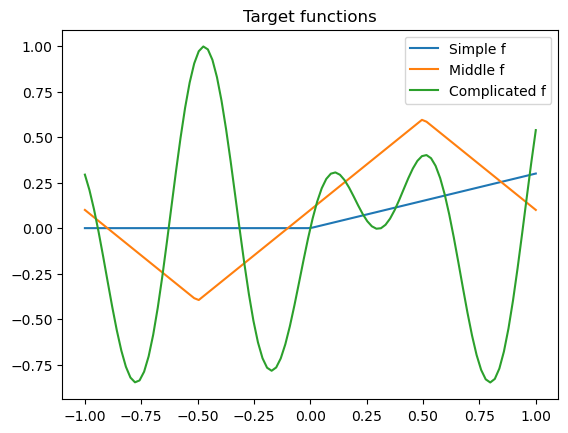

In [ ]:
def simple_f(x):
    return np.maximum(0.3 * x, 0)


def middle_f(x):
    return np.abs(x + 0.5) - 2 * np.maximum(x - 0.5, 0) - 0.4


def complex_f(x):
    return np.sin(10 * x) * np.cos(2 * x + 1)


def gauss_f(x, d=1, x0=0, sigma=8):
    return np.exp(-np.dot((x - x0), (x - x0)) / 2 * (sigma**2))


xs = np.linspace(-1, 1, 100)
plt.plot(xs, [simple_f(x) for x in xs], label="Simple f")
plt.plot(xs, [middle_f(x) for x in xs], label="Middle f")
plt.plot(xs, [complex_f(x) for x in xs], label="Complicated f")
# plt.plot(xs, [gauss_f(x) for x in xs], label="Gauss f")
plt.title("Target functions")
plt.legend()
plt.show()

In [4]:
class Data:
    """
    Generates batches of (labels, responses) pairs, of the form (x_i,  f(x_i) + noise).
    x_i are 1-dimensional
    """

    def __init__(
        self, n=1000, xmin=-1, xmax=1, noise_level=1e-2, type="simple", input_dim=1
    ):
        self.n = n  # number of data points
        self.xmin = xmin  # min feature
        self.xmax = xmax  # max feature

        self.noise_level = noise_level  # gaussian noise of variance noise_level**2
        self.type = type  # define the target function

        self.inputs = torch.empty(n, input_dim)  # all inputs in our dataset
        self.outputs = torch.empty(n, 1)  # all responses

        self.d = input_dim

        self.fill_data()  # fill inputs and outputs

        self.pass_order = np.arange(
            n
        )  # will be shuffled every time we go through the data
        self.current_position = (
            0  # current position in pass order. Used to generate batches.
        )

    def true_f(self, x):
        if self.type == "simple":
            return simple_f(x)
        if self.type == "middle":
            return middle_f(x)
        if self.type == "complex":
            return complex_f(x)
        if self.type == "gauss":
            x0 = 0.1
            return gauss_f(x, d=self.d, x0=x0)

    def next_batch(self, batch_size=10):
        pos = self.current_position
        self.current_position = (self.current_position + batch_size) % self.n

        indices = self.pass_order[pos : pos + batch_size]
        input_batch = torch.stack([self.inputs[i] for i in indices])
        output_batch = torch.stack([self.outputs[i] for i in indices])

        if pos + batch_size > self.n:
            np.random.shuffle(self.pass_order)

        return input_batch, output_batch

    def fill_data(self):
        for i in range(self.n):
            x = self.xmin + torch.rand(self.d) * (self.xmax - self.xmin)
            y = self.true_f(x)
            self.inputs[i] = x
            self.outputs[i] = y + self.noise_level * np.random.normal() * (
                np.random.rand() < 0.15
            )

    def __len__(self):
        return self.n

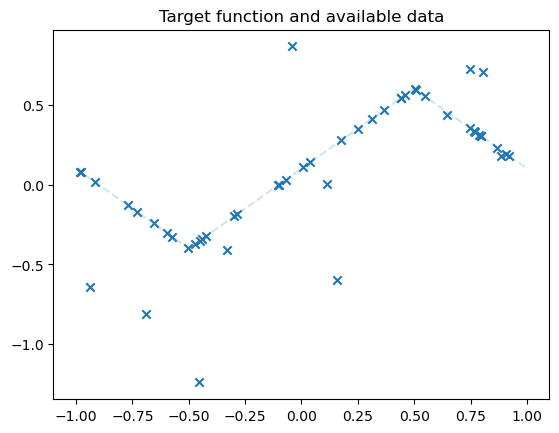

In [10]:
dataset = Data(50, type="middle", noise_level=1)
plt.title("Target function and available data")
plt.plot(xs, dataset.true_f(xs), linestyle="--", alpha=0.2, label="True values")
plt.scatter(dataset.inputs, dataset.outputs, marker="x")
plt.show()

### 4. Train a network

In this section we train a network to match the target function, given the observed points. 

In [11]:
hidden_dim = 100
mlp = MLPdeep(hidden_dim=hidden_dim)  # Initialize a network

total_train_steps = 0  # for log keeping
all_losses = []  # for log keeping

In [12]:
def plot(net, dataset, n_points=1000):
    with torch.no_grad():
        xs = torch.linspace(-1, 1, n_points).reshape(n_points, 1)
        nn_values = net(xs)
        true_vals = dataset.true_f(xs)
        plt.plot(xs, true_vals, linestyle="--", alpha=0.2, label="True values")
        plt.plot(xs, nn_values, label="Current approx")
        plt.scatter(dataset.inputs, dataset.outputs, marker="x", label="data")

        print(f"Squared error of O pred: {np.linalg.norm(true_vals)**2 / n_points}")
        print(
            f"Squared error of mlp: {np.linalg.norm(nn_values - true_vals)**2 / n_points}"
        )
        print(f"total_train_steps : {total_train_steps}")

    plt.legend()

Squared error of O pred: 0.0932499235305304
Squared error of mlp: 0.12067063650204454
total_train_steps : 0


Text(0.5, 1.0, 'At initialization')

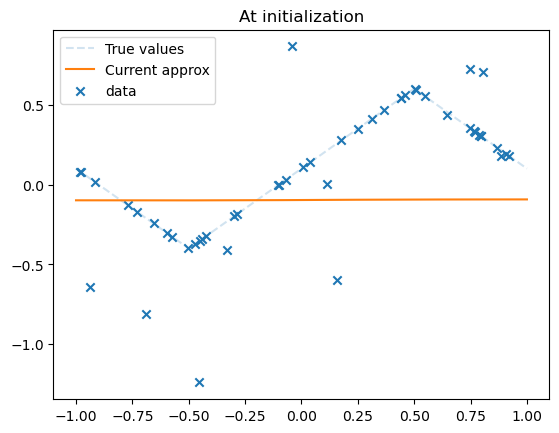

In [14]:
plot(mlp, dataset)
plt.title("At initialization")

## Training

We are going to try to compute an approximate least-squares neural network, by minimizing
$$
    \frac{1}{n} \sum_{ \text{data}} (h_w(x_i) - y_i)^2
$$
To do so, we use the standard neural net training procedure: (stochastic) gradient descent on then weights of the neural network. 
$$
    w_{t+1} = w_t - \mathrm{lr}  \cdot \nabla_w f(w_t; (x_i, y_i))
$$
where
$$
    f(w; (x_i, y_i) ) = \frac{1}{n} \sum_{ \text{data}} (h_w(x_i) - y_i)^2 \, . 
$$

### Defining the optimizer and loss

You can come back and tune the learning rate if necessary. 

In [16]:
optimizer = optim.SGD(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()

Write the training procedure. Go to TP1 if you need a reminder on the syntax. 

Total training steps : 3000000


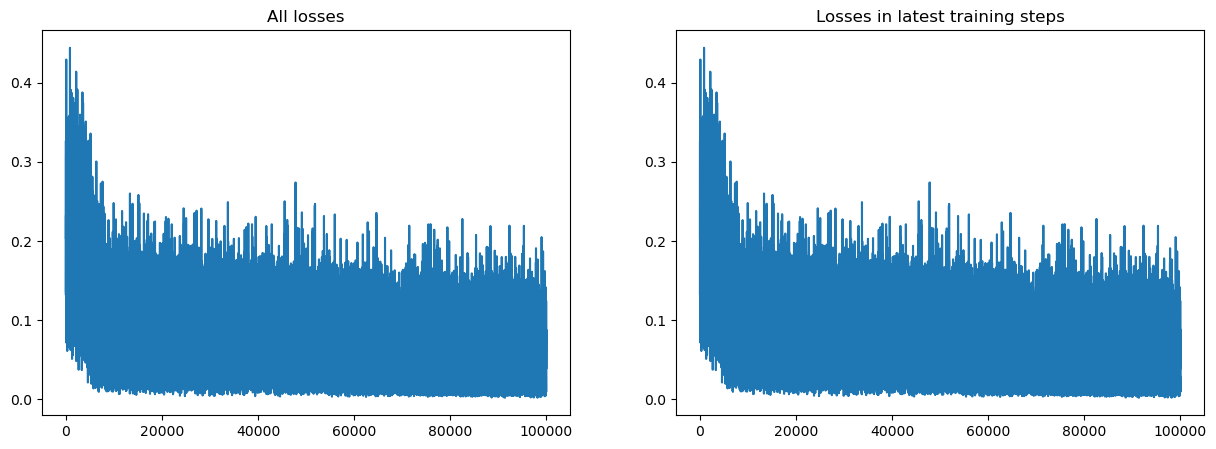

In [17]:
N_steps = 100000
batch_size = 30

losses = []

for i in range(N_steps):
    inputs, labels = dataset.next_batch(batch_size)
    # print(inputs.shape)
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = mlp(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    losses.append(loss.detach().numpy())
    optimizer.step()
    total_train_steps += batch_size

all_losses += losses

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

print(f"Total training steps : {total_train_steps}")
axs[0].set_title("All losses")
axs[0].plot(all_losses)
axs[1].set_title("Losses in latest training steps")
axs[1].plot(losses)

plt.show()


Total training steps : 28210000


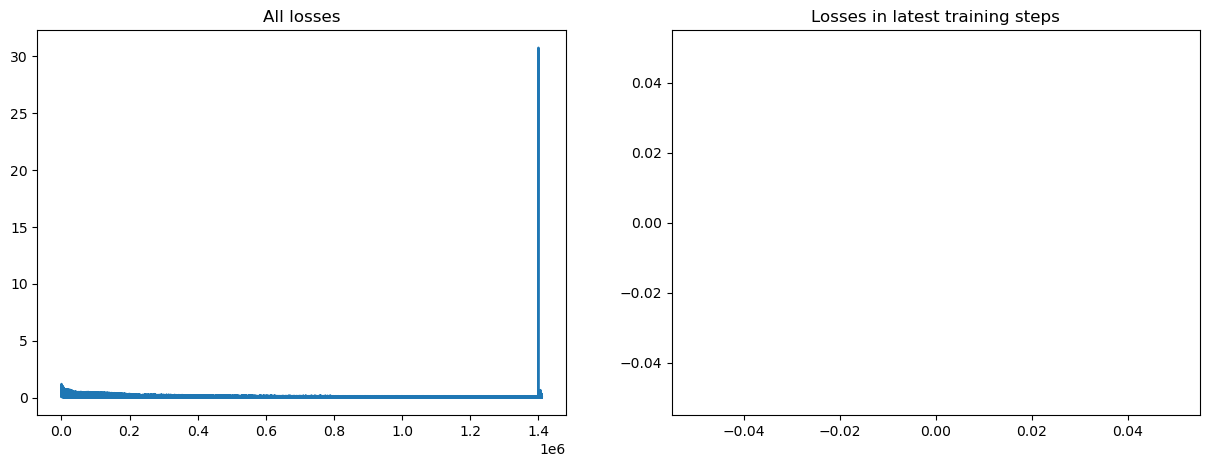

In [ ]:
N_steps = 1000
batch_size = 10

losses = []

for i in range(N_steps):
    # YOUR CODE HERE

    # do not forget to fill 'losses' for tracking the train loss
    total_train_steps += batch_size

all_losses += losses

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

print(f"Total training steps : {total_train_steps}")
axs[0].set_title("All losses")
axs[0].plot(all_losses)
axs[1].set_title("Losses in latest training steps")
axs[1].plot(losses)

plt.show()

Squared error of O pred: 0.0932499235305304
Squared error of mlp: 0.007037043430686993
total_train_steps : 3000000


Text(0.5, 1.0, 'After training')

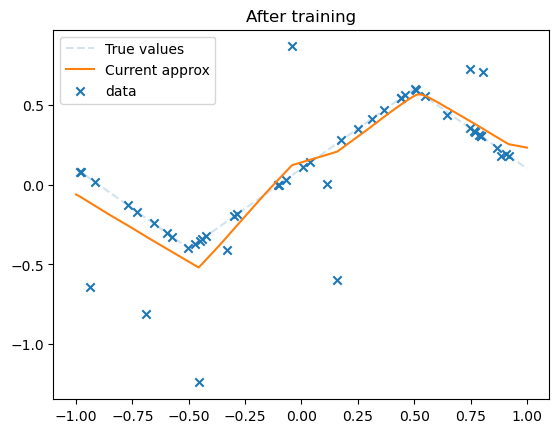

In [18]:
plot(mlp, dataset)
plt.title("After training")

Train your network until the plot looks good. 

## 5 - Compare the performances on different functions for different depths.


Plot the approximation after $N \approx 1\,000\,000$ steps for the two architectures (with, e.g., hidden_dim = 15) on the three functions. 

In [19]:
def train(net, dataset, N_steps, batch_size, lr):
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    for _ in range(N_steps):
        inputs, labels = dataset.next_batch(batch_size)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        losses.append(torch.mean(loss.detach()))

        optimizer.step()
    return losses


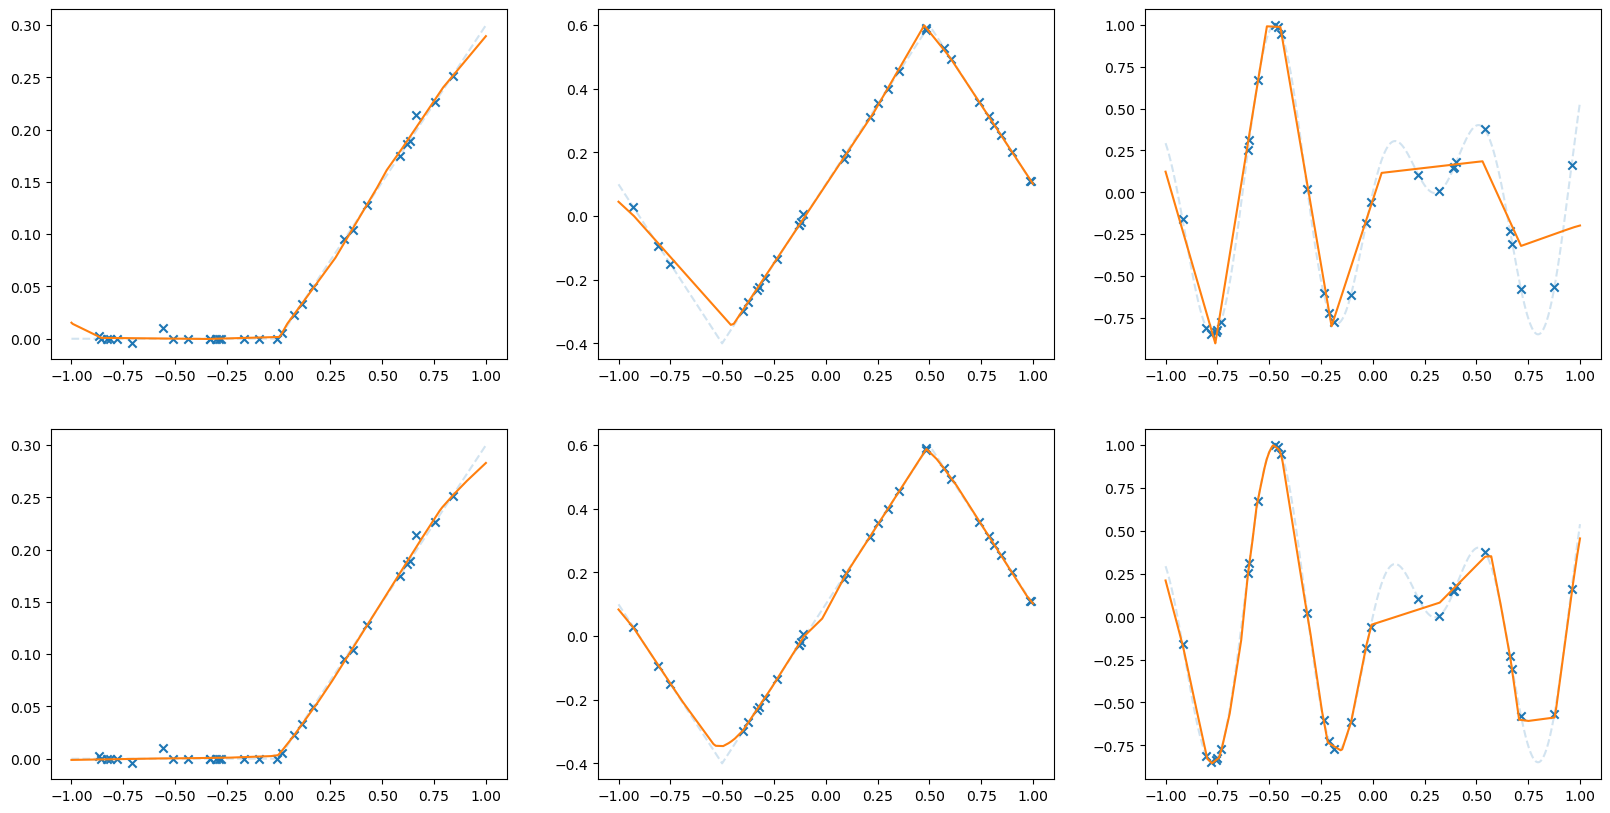

In [20]:
n_points = 10000

all_data_types = ["simple", "middle", "complex"]
all_net_types = ["shallow", "deep"]

N_steps = 100_000
batch_size = 10
lr = 0.01

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, type in enumerate(all_data_types):
    dataset = Data(30, type=type)

    net_shallow = MLPshallow(hidden_dim=20)
    train(net_shallow, dataset, N_steps, batch_size, lr)

    xs = torch.linspace(-1, 1, n_points).reshape(n_points, 1)
    nn_values = net_shallow(xs).detach().numpy()
    true_vals = dataset.true_f(xs)
    axs[0, i].plot(xs, true_vals, linestyle="--", alpha=0.2, label="True values")
    axs[0, i].plot(xs, nn_values, label="Current approx")
    axs[0, i].scatter(dataset.inputs, dataset.outputs, marker="x", label="data")

    net_deep = MLPdeep(hidden_dim=20)
    train(net_deep, dataset, N_steps, batch_size, lr)

    xs = torch.linspace(-1, 1, n_points).reshape(n_points, 1)
    nn_values = net_deep(xs).detach().numpy()
    true_vals = dataset.true_f(xs)
    axs[1, i].plot(xs, true_vals, linestyle="--", alpha=0.2, label="True values")
    axs[1, i].plot(xs, nn_values, label="Current approx")
    axs[1, i].scatter(dataset.inputs, dataset.outputs, marker="x", label="data")


Approximating a gaussian function?

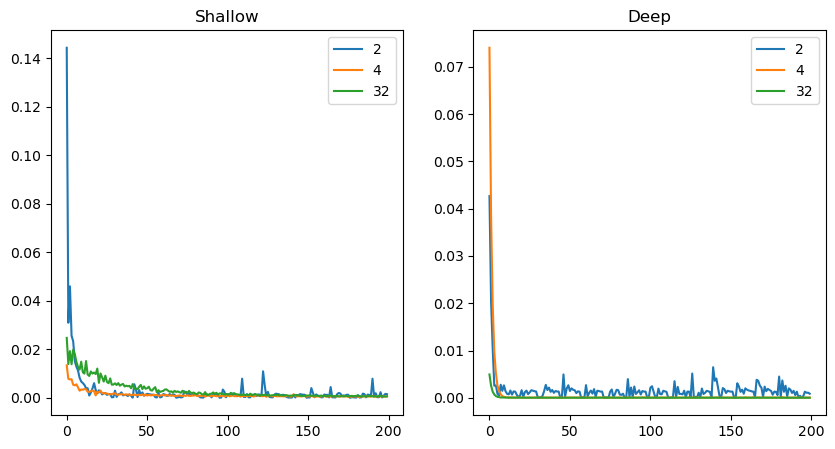

In [ ]:
ds = [2, 4, 32]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for d in ds:
    dataset = Data(d**3 + 100, type="gauss", input_dim=d)
    N_steps = 200
    batch_size = 100
    lr = 0.1

    net_shallow = MLPshallow(hidden_dim=20, input_dim=d)
    axs[0].set_title("Shallow")
    axs[0].plot(train(net_shallow, dataset, N_steps, batch_size, lr), label=d)
    axs[0].legend()

    net_deep = MLPdeep(hidden_dim=20, input_dim=d)
    axs[1].set_title("Deep")
    axs[1].plot(train(net_deep, dataset, N_steps, batch_size, lr), label=d)
    plt.legend()

# xs = torch.linspace(-1, 1, n_points).reshape(n_points, 1)
# nn_values = net_deep(xs).detach().numpy()
# true_vals = dataset.true_f(xs)
# axs[1, i].plot(xs, true_vals, linestyle="--", alpha=0.2, label="True values")
# axs[1, i].plot(xs, nn_values, label="Current approx")
# axs[1, i].scatter(dataset.inputs, dataset.outputs, marker="x", label="data")

This is not good practice to train networks. For performance, the hyperparameters for each problem and architecture should be tuned separately and you should monitor the state of the network (at least plot the losses during training).

You can use the following code snippet to save your network.

In [ ]:
# mlp = MLPdeep() # MLPshallow()
# PATH = f'./{dataset.type}_{mlp.net_type}.pth'
# torch.save(mlp.state_dict(), PATH)

# net = MLPdeep() # MLPshallow()
# net.load_state_dict(torch.load(PATH))